# Feature Selection

**PROCESS**
1. Load the Data, including the labels (-1 and 1 for UCI Madelon, and 0 and 1 for Cook Madelon datasets).
2. Use the raw data with all of the original features (500 for UCI Madelon, 1,000 for Cook Madelon) 
3. Build feature selection pipelines that include the following feature selection methods:
        - SelectKBest 
        - SelectFromModel(LogisticRegression)
        - Recursive Feature Eliminator (LogisticRegression)
4. Calculate the frequency of the returned feature numbers for each dataset as a means of 'voting' for which features would be considered the most relevant of the total 500 and 1,000 in the UCI and Cook Madelon dataset, respectively.
5. Compare the selected features in each case to the Feature Extraction methods implemented in Notebook 2

**RESULTS**

**Both Cook & UCI Madelon:** SelectKBest appears to be the best feature selector based on the number of features that matched up with the features that emerged from the Feature Extraction process in Notebook 2.

In [3]:
import numpy as np, pandas as pd
import matplotlib.pyplot as plt, seaborn as sns
%matplotlib inline

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from scipy import stats

from sklearn.feature_selection import SelectFromModel, SelectKBest, RFE

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

### Load Data

**UCI Madelon**
- Load in a sample (600) of the original train set (2,000 samples) with all 500 features.
- Load in the valid set, 600 samples by 500 features, with the labels included as an extra column.

In [5]:
pwd

'/home/jovyan/ipynb'

In [6]:
madelon_train = pd.read_pickle('../assets/pickled_samples/madelon_sample_train.p')
madelon_train_labels = pd.read_pickle('../assets/pickled_samples/madelon_sample_train_labels.p')

In [7]:
madelon_valid = pd.read_pickle('../assets/pickled_samples/madelon_valid_total.p')

In [8]:
display(madelon_train.shape)
display(madelon_train_labels.shape)
display(madelon_valid.shape)

(600, 500)

(600,)

(600, 501)

In [9]:
madelon_train.head()

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
1239,492,526,464,476,500,479,445,475,488,467,...,521,477,489,456,487,486,484,467,507,469
1252,479,488,615,478,476,485,471,476,496,475,...,479,473,472,287,479,493,473,465,496,484
988,474,505,502,469,494,477,409,478,500,485,...,500,463,497,482,482,521,482,482,469,456
457,493,499,534,491,489,480,530,479,487,473,...,487,484,496,383,477,486,491,472,549,499
886,476,518,504,486,502,478,460,474,486,480,...,466,480,475,682,506,489,486,468,505,501


In [10]:
madelon_train_labels.head()

1239    1
1252   -1
988    -1
457     1
886     1
Name: target, dtype: int64

In [11]:
madelon_valid.head()

,0,1,2,3,4,5,6,7,8,9,...,491,492,493,494,495,496,497,498,499,target
0,483,454,513,495,523,469,453,477,506,479,...,480,543,259,413,520,485,498,523,510,-1
1,485,508,493,487,478,472,504,476,479,475,...,480,535,534,514,452,484,495,548,477,-1
2,483,521,507,475,493,486,421,475,496,483,...,476,498,495,508,528,486,465,508,503,-1
3,474,504,576,480,553,483,524,478,483,483,...,475,470,463,509,525,479,467,552,517,1
4,495,474,523,479,495,488,485,476,497,478,...,471,522,343,509,520,475,493,506,491,-1


**Cook Madelon**
- Load in a sample of the train set, 6,600 samples x 1,000 features.
- Extra columns include the `_id` column and the `target` column.

In [12]:
cook_samples = pd.read_pickle('../assets/pickled_samples/cook_total_samples.p')

In [13]:
cook_samples.shape

(6600, 1002)

In [14]:
cook_samples.head()

,_id,feat_000,feat_001,feat_002,feat_003,feat_004,feat_005,feat_006,feat_007,feat_008,...,feat_991,feat_992,feat_993,feat_994,feat_995,feat_996,feat_997,feat_998,feat_999,target
0,35870,0.371429,1.557665,0.088738,-0.568426,0.279411,0.553009,-2.263165,0.322735,-0.770665,...,-0.006892,0.504680,-1.534529,0.120796,1.485370,0.481770,0.499728,-2.032250,-0.245348,1
1,92973,-0.044490,-1.042972,0.245990,-0.187297,1.355108,-0.086559,-0.409865,-0.156749,-0.388948,...,-0.363377,-0.313348,-0.518927,-0.515884,0.345514,-0.140779,-0.113291,1.161730,-0.616847,0
2,56479,0.043489,0.440636,0.047697,-1.933592,1.219459,0.182951,-2.266318,-0.721327,0.510775,...,-1.811937,0.563980,1.152395,-0.060437,-0.723646,0.529993,1.599007,-0.053172,0.581611,0
3,119182,0.567497,0.313351,0.744730,-1.350541,-0.068053,0.588990,0.290120,0.229521,0.848661,...,0.308947,-0.315620,-0.703337,0.499579,1.128113,-0.067667,0.086741,-0.861531,0.361497,1
4,34782,-0.111258,-0.682838,-0.561106,-0.381560,0.540490,-1.115611,-1.473109,0.728398,-0.267222,...,1.522104,-0.325736,0.967692,0.919213,2.192081,-0.672942,-0.325374,-0.782994,0.662257,1


### Train Test Split

**UCI Madelon**
- The train data is already split off into X_train and y_train, with X_train being the `madelon_train` dataframe, and the y_train being the `madelon_train_labels` dataframe.
- The valid data is NOT separated into an X_test and a y_test, since the target is included in the `madelon_valid` dataframe. The below code will separate the `madelon_valid` dataframe into an X_test and y_test to prepare the data for each of the 7 Feature Selection methods below. 
- Because there are 600 samples in the training data, and 600 samples on the validation data, this is a 50/50 train-test-split.

In [15]:
madelonXtrain = madelon_train
madelonytrain = madelon_train_labels

In [16]:
madelonXtest = madelon_valid.drop('target', axis=1)
madelonytest = madelon_valid['target']

In [17]:
display(madelonXtrain.shape)
display(madelonXtest.shape)
display(madelonytrain.shape)
display(madelonytest.shape)

(600, 500)

(600, 500)

(600,)

(600,)

**Cook Madelon**
- The `_id` column will be dropped.
- The target column separated and defined as `y`
- The samples with all 1,000 features will be defined as `X`
- Then train / test / split will be completed in preparation to feed into each of the Feature Selection methods below.

In [18]:
cookX = cook_samples.iloc[:, 1:1001]
cooky = cook_samples['target']

In [19]:
cookX.head()

,feat_000,feat_001,feat_002,feat_003,feat_004,feat_005,feat_006,feat_007,feat_008,feat_009,...,feat_990,feat_991,feat_992,feat_993,feat_994,feat_995,feat_996,feat_997,feat_998,feat_999
0,0.371429,1.557665,0.088738,-0.568426,0.279411,0.553009,-2.263165,0.322735,-0.770665,-0.489383,...,-0.796701,-0.006892,0.504680,-1.534529,0.120796,1.485370,0.481770,0.499728,-2.032250,-0.245348
1,-0.044490,-1.042972,0.245990,-0.187297,1.355108,-0.086559,-0.409865,-0.156749,-0.388948,0.732151,...,0.597574,-0.363377,-0.313348,-0.518927,-0.515884,0.345514,-0.140779,-0.113291,1.161730,-0.616847
2,0.043489,0.440636,0.047697,-1.933592,1.219459,0.182951,-2.266318,-0.721327,0.510775,0.404986,...,-0.488234,-1.811937,0.563980,1.152395,-0.060437,-0.723646,0.529993,1.599007,-0.053172,0.581611
3,0.567497,0.313351,0.744730,-1.350541,-0.068053,0.588990,0.290120,0.229521,0.848661,0.546417,...,-0.130573,0.308947,-0.315620,-0.703337,0.499579,1.128113,-0.067667,0.086741,-0.861531,0.361497
4,-0.111258,-0.682838,-0.561106,-0.381560,0.540490,-1.115611,-1.473109,0.728398,-0.267222,0.238052,...,0.229635,1.522104,-0.325736,0.967692,0.919213,2.192081,-0.672942,-0.325374,-0.782994,0.662257


In [20]:
cooky.head()

0    1
1    0
2    0
3    1
4    1
Name: target, dtype: int64

In [21]:
cookXtrain, cookXtest, cookytrain, cookytest = train_test_split(cookX, cooky, test_size=0.25, random_state=42)

In [22]:
display(cookXtrain.shape)
display(cookXtest.shape)
display(cookytrain.shape)
display(cookytest.shape)

(4950, 1000)

(1650, 1000)

(4950,)

(1650,)

### Feature Selection
- The below Feature Selection pipelines will be setup in a manner using sklearn's `Pipeline` with named steps in order to also scale and deskew the data.
    - The Scalers used will 1st be MinMaxScaler to transform the datapoints to be *greater than or equal to* 0
    - The transfomed data will then be passed into a boxcox in order to remove skew from the data
    - The deskewed data will be subsequently passed into yet another scaler (StandardScaler) to normalize the data and center the means on 0 with standard deviations of 1 for each feature.
    
    
- The preprocessed data will then be passed into the various Feature Selection methods

#### 1.  SelectKBest 
        

##### UCI Madelon

In [23]:
selectk_pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('select', SelectKBest(k=20))
])

In [24]:
selectk_pipe.fit(madelonXtrain, madelonytrain)

Pipeline(steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('select', SelectKBest(k=20, score_func=<function f_classif at 0x7f83a37df400>))])

In [25]:
feature_scores = (selectk_pipe.named_steps['select'].scores_)
len(feature_scores)

500

In [26]:
feature_scores[:5]

array([ 4.32933558,  0.00986097,  1.48305392,  0.06718145,  0.65203681])

In [40]:
madelon_feature_pvalues = list(zip(madelonXtrain.columns, selectk_pipe.named_steps['select'].pvalues_))

In [53]:
madelon_top20_feat_pvalues = sorted(madelon_feature_pvalues, key=lambda x: x[1])[:20]
madelon_top20_feat_pvalues

[(475, 1.4207424626682647e-07),
 (241, 2.513287266150833e-07),
 (64, 7.4376822979295423e-05),
 (336, 7.900880228032281e-05),
 (338, 0.00033614550511557934),
 (323, 0.00035255600738568095),
 (13, 0.0014051540695217857),
 (128, 0.0018552284053610804),
 (61, 0.0018625483804090746),
 (105, 0.0020585892068387549),
 (424, 0.0030438221842564867),
 (454, 0.0049093364152365988),
 (447, 0.0058280051832057212),
 (59, 0.006058028631651796),
 (226, 0.006620621419516806),
 (190, 0.0082570890085381307),
 (248, 0.0094222708901385965),
 (299, 0.0096420020301334741),
 (238, 0.010145463174096191),
 (222, 0.010630647456117638)]

In [83]:
madelon_top20_pvalue_indices = [(x[0]) for x in madelon_top20_feat_pvalues]
madelon_top20_pvalues = [x[1] for x in madelon_top20_feat_pvalues]

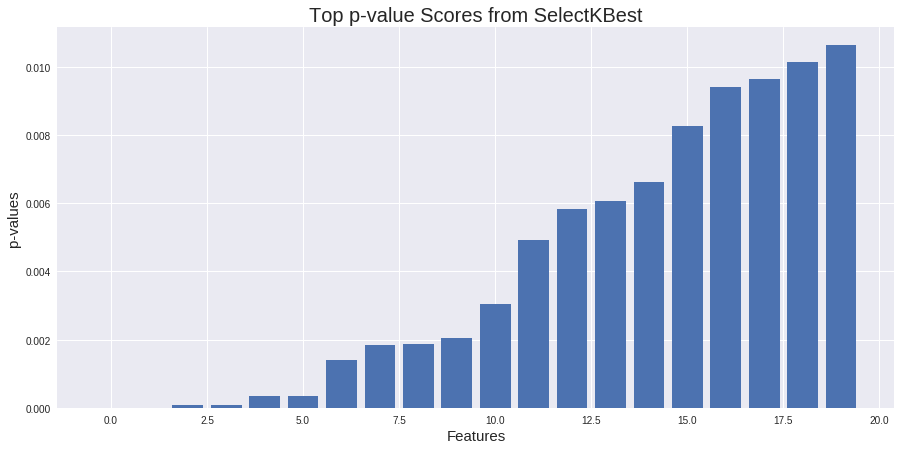

In [86]:
plt.figure(figsize=(15,7))
plt.bar(left=[i for i in range(20)], height=madelon_top20_pvalues)
plt.xlabel('Features', size=15)
plt.ylabel('p-values', size=15)
plt.title('Top p-value Scores from SelectKBest', size=20)
plt.show()

Build a dataframe to hold the selected features from each method

In [26]:
chosen_feat = pd.DataFrame()
chosen_feat['SKB-UCI'] = [x[0] for x in sorted(top20_selectk_feat)]

##### Cook-Madelon

In [27]:
selectk_pipe.fit(cookXtrain, cookytrain)

Pipeline(steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('select', SelectKBest(k=20, score_func=<function f_classif at 0x7f0c4ec92b70>))])

In [28]:
top20_selectk_cookfeat = sorted(enumerate(selectk_pipe.named_steps['select'].scores_), key=lambda x: x[1], \
                                reverse=True)[:20]
top20_selectk_cookfeat

[(269, 250.89873899248039),
 (681, 193.30342738846835),
 (701, 164.4796508996005),
 (920, 152.9958832625789),
 (341, 86.067745296405775),
 (769, 73.818720208622196),
 (829, 71.885999087541904),
 (315, 62.704548313671197),
 (808, 43.558646530438402),
 (867, 37.121069387931804),
 (504, 25.598766155759449),
 (736, 21.556972174761956),
 (724, 15.12394951599455),
 (308, 13.452447855520001),
 (526, 13.181088922561033),
 (336, 13.020231201724158),
 (342, 11.418255202027174),
 (577, 10.388985531381943),
 (257, 9.2108770328108776),
 (391, 9.1437954717579419)]

In [29]:
chosen_feat['SKB-Cook'] = [x[0] for x in sorted(top20_selectk_cookfeat, key=lambda x: x[0])]
chosen_feat.head()

,SKB-UCI,SKB-Cook
0,13,257
1,59,269
2,61,308
3,64,315
4,105,336


#### 2. SelectFromModel(LogisticRegression)
        

In [30]:
sfm_logreg_pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('sfmlogreg', SelectFromModel(LogisticRegression(penalty='l1', C=0.0375, n_jobs=-1, random_state=42)))
])

##### UCI Madelon

In [31]:
sfm_logreg_pipe.fit(madelonXtrain, madelonytrain)

Pipeline(steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('sfmlogreg', SelectFromModel(estimator=LogisticRegression(C=0.0375, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=-1, penalty='l1', random_state=42,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False),
        prefit=False, threshold=None))])

In [32]:
top20_sfmlogreg_uci = madelonXtrain.columns[sfm_logreg_pipe.named_steps['sfmlogreg'].get_support()][:20]
chosen_feat['SFM-LogReg-UCI'] = top20_sfmlogreg_uci

In [33]:
chosen_feat.head()

,SKB-UCI,SKB-Cook,SFM-LogReg-UCI
0,13,257,13
1,59,269,15
2,61,308,44
3,64,315,59
4,105,336,61


##### Cook Madelon

In [34]:
sfm_logreg_pipe_cook = Pipeline([
    ('scaler', StandardScaler()),
    ('sfmlogreg', SelectFromModel(LogisticRegression(penalty='l1', C=0.01145, n_jobs=-1, random_state=42)))
])

In [35]:
sfm_logreg_pipe_cook.fit(cookXtrain, cookytrain)

Pipeline(steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('sfmlogreg', SelectFromModel(estimator=LogisticRegression(C=0.01145, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=-1, penalty='l1', random_state=42,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False),
        prefit=False, threshold=None))])

In [36]:
top20cook_sfmlogreg_feat = cookXtrain.columns[sfm_logreg_pipe_cook.named_steps['sfmlogreg'].get_support()][:20]
top20cook_sfmlogreg_feat

Index(['feat_029', 'feat_155', 'feat_269', 'feat_342', 'feat_369', 'feat_391',
       'feat_398', 'feat_452', 'feat_471', 'feat_577', 'feat_681', 'feat_694',
       'feat_705', 'feat_743', 'feat_754', 'feat_808', 'feat_829', 'feat_832',
       'feat_878', 'feat_920'],
      dtype='object')

In [37]:
type(top20cook_sfmlogreg_feat[0])

str

In [38]:
chosen_feat['SFM-LogReg-Cook']=[int(x[6:]) for x in top20cook_sfmlogreg_feat]
chosen_feat.head()

,SKB-UCI,SKB-Cook,SFM-LogReg-UCI,SFM-LogReg-Cook
0,13,257,13,29
1,59,269,15,55
2,61,308,44,69
3,64,315,59,42
4,105,336,61,69


#### 3. Recursive Feature Eliminator (LogisticRegression)
       

In [62]:
rfe_logreg_pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('rfelogreg', RFE(LogisticRegression(penalty='l1', C=0.1, n_jobs=-1, random_state=42), n_features_to_select=20))
])

##### UCI Madelon

In [63]:
rfe_logreg_pipe.fit(madelonXtrain, madelonytrain)

Pipeline(steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('rfelogreg', RFE(estimator=LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=-1,
          penalty='l1', random_state=42, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
  n_features_to_select=20, step=1, verbose=0))])

In [66]:
chosen_feat['RFE-LogReg-UCI']= madelonXtrain.columns[rfe_logreg_pipe.named_steps['rfelogreg'].get_support()]
chosen_feat.head()

,SKB-UCI,SKB-Cook,SFM-LogReg-UCI,SFM-LogReg-Cook,RFE-LogReg-UCI
0,13,257,13,29,0
1,59,269,15,55,13
2,61,308,44,69,44
3,64,315,59,42,59
4,105,336,61,69,61


##### Cook Madelon

In [67]:
rfe_logreg_pipe.fit(cookXtrain, cookytrain)

Pipeline(steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('rfelogreg', RFE(estimator=LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=-1,
          penalty='l1', random_state=42, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
  n_features_to_select=20, step=1, verbose=0))])

In [72]:
top20_rfe_cook_feat = cookXtrain.columns[rfe_logreg_pipe.named_steps['rfelogreg'].get_support()]

In [74]:
top20_cook_feat_rfelogreg = [int(x[6:]) for x in top20_rfe_cook_feat]
top20_cook_feat_rfelogreg

[55, 69, 42, 69, 91, 98, 52, 71, 47, 77, 81, 94, 5, 43, 84, 8, 32, 78, 20, 37]

In [87]:
chosen_feat['RFE-LogReg-Cook'] = sorted(top20_cook_feat_rfelogreg)

### Compare the Most Frequent Features to the 20 Features Extracted in Notebook 2

In [90]:
UCI_feat_extracted =[28, 48, 64, 105, 128, 153, 241, 281, 318, 336, 338, 378, 433, 442, 451, 453, 455, 472, 475, 493]

In [91]:
cook_feat_extracted = [257, 269, 308, 315, 336, 341, 395, 504, 526, 639, 681, 701, 724, 736, 769, 808, 829, 867, 920, 956]

In [92]:
chosen_feat['UCI-Feat-Extracted'] = UCI_feat_extracted
chosen_feat['Cook-Feat-Extracted'] = cook_feat_extracted

In [139]:
chosen_feat.head()

,SKB-UCI,SKB-Cook,SFM-LogReg-UCI,SFM-LogReg-Cook,RFE-LogReg-UCI,RFE-LogReg-Cook,UCI-Feat-Extracted,Cook-Feat-Extracted
0,13,257,13,29,0,5,28,257
1,59,269,15,55,13,8,48,269
2,61,308,44,69,44,20,64,308
3,64,315,59,42,59,32,105,315
4,105,336,61,69,61,37,128,336


**Need to split of Cook features from UCI features given the different feature selection methods.**

In [140]:
cook_chosen_feat_df = chosen_feat[['SKB-Cook', 'SFM-LogReg-Cook', 'RFE-LogReg-Cook', 'Cook-Feat-Extracted']]
uci_chosen_feat_df = chosen_feat[['SKB-UCI', 'SFM-LogReg-UCI', 'RFE-LogReg-UCI', 'UCI-Feat-Extracted']]

In [152]:
cook_chosen_feat_df

,SKB-Cook,SFM-LogReg-Cook,RFE-LogReg-Cook,Cook-Feat-Extracted
0,257,29,5,257
1,269,55,8,269
2,308,69,20,308
3,315,42,32,315
4,336,69,37,336
5,341,91,42,341
6,342,98,43,395
7,391,52,47,504
8,504,71,52,526
9,526,77,55,639


In [153]:
uci_chosen_feat_df

,SKB-UCI,SFM-LogReg-UCI,RFE-LogReg-UCI,UCI-Feat-Extracted
0,13,13,0,28
1,59,15,13,48
2,61,44,44,64
3,64,59,59,105
4,105,61,61,128
5,128,120,120,153
6,190,149,149,241
7,222,157,157,281
8,226,190,199,318
9,238,222,226,336


### Voting by Calculating Frequency of Features That Occured in Each of the 3 Feature Selection Methods Above

In [141]:
def feature_frequency_count(dataframe):
    feature_count_dict = {}
    
    for column in dataframe.columns:
        for element in dataframe[column]:
            if element in feature_count_dict.keys():
                feature_count_dict[element] += 1
            else:
                feature_count_dict[element] = 1
    return feature_count_dict

In [142]:
cook_feat_count_dict = feature_frequency_count(cook_chosen_feat_df)
uci_feat_count_dict = feature_frequency_count(uci_chosen_feat_df)

In [149]:
cook_highest_freq_features = [(key, value) for key, value in cook_feat_count_dict.items() if value > 2]
uci_highest_freq_features = [(key, value) for key, value in uci_feat_count_dict.items() if value > 2]

In [150]:
cook_highest_freq_features

[(69, 4)]

In [151]:
uci_highest_freq_features

[(13, 3),
 (59, 3),
 (61, 3),
 (226, 3),
 (238, 3),
 (248, 3),
 (323, 3),
 (424, 3),
 (475, 3)]